In [1]:
import numpy as np 
import matplotlib.pyplot as plt
%matplotlib inline
# use %matplotlib notebook for interactive plots here in the notebook
from igor.binarywave import Waves

In [2]:
import lmfit
from lmfit import Model
import pickle

In [3]:
e=1.60217646e-19;  mstar=8.724125937209915e-32; h=6.626068e-34; G_0=7.45e-5; hbar=h/2.0/np.pi;
# D=5.106250385935459e-03 # diffusion constant

from scipy.special import psi

# basic fit function
def wlcorr(b, bo, ro, Bphi, Bi, Bstar, lin, A):
    """ Weak localization peak fitting function. Adapted from Igor code. """
    b=b-bo

    z1=np.array(abs(b)/abs(Bphi), dtype=np.float64)
    F1=np.log(z1)+psi(0.5+1/z1)

    z2=np.array(abs(b)/(abs(Bphi)+2*abs(Bi)), dtype=np.float64)
    F2=np.log(z2)+psi(0.5+1/z2)

    z3=np.array(abs(b)/(abs(Bphi)+abs(Bstar)), dtype=np.float64)
    F3=np.log(z3)+psi(0.5+1/z3)

    return (lin*b) + ro - A*ro**2.0*(e*e/np.pi/h*(F1-F2-2*F3))
# unit of Bphi is determined by unit of denominator--abs(b) or similar, if the b input is in mT, then, Bphi in mT, if the B input is in T, then, Bphi in T

def wlcorrd(b,  Bphi, Bi, Bstar,bo, c1,c2):
    """ Weak localization peak fitting function. Adapted from Igor code. """
    

    z1=np.array(abs(b-bo)/1000/abs(Bphi), dtype=np.float64)
    F1=np.log(z1)+psi(0.5+1/z1)

    z2=np.array(abs(b-bo)/1000/(abs(Bphi)+2*abs(Bi)), dtype=np.float64)
    F2=np.log(z2)+psi(0.5+1/z2)

    z3=np.array(abs(b-bo)/1000/(abs(Bphi)+abs(Bstar)), dtype=np.float64)
    F3=np.log(z3)+psi(0.5+1/z3)

    return c1*(b-bo) + c2 - (e*e/np.pi/h*(F1-F2-2*F3))
# unit of Bphi is determined by unit of denominator---abs(b-bo)/1000, for input b in mT (thus bo also in mT), abs(b-bo)/1000 is in T, thus Bphi in T


###########
#function mgrapheneWLd(b,bphi,bi,bs,b0,c1,c2)
#     variable b,bphi,bi,bs,b0,c1,c2
#     variable t1 = ffunc((b-b0)/1000/abs(bphi))
#     variable t2 = ffunc((b-b0)/1000/(abs(bphi)+2*abs(bi)))
#     variable t3 = ffunc((b-b0)/1000/(abs(bphi)+abs(bs))) 
#     return -(t1 - t2 - 2*t3)*3.87e-5/pi+c1*(b-b0)+c2
#end
###########
#       K0     =0.0010882 ± 1.06e-005
#       K1     =-0.0012604 ± 1.63e-005
#       K2     =-0.030482 ± 0.00019
#       K3     =3.3877 ± 0.0215
#       K4     =9.5847e-009 ± 1.23e-010
#       K5     =-1.9421e-007 ± 3.52e-008

### parabola to fit curvature only ###
def parabola(b, bo, ro, a):
    """ Inverse parabola for fitting  """
    return ro - a*np.power(b - bo, 2)


def find_nearest(array, value):
    idx = (np.abs(array-value)).argmin()
    return idx


def round_to(n, precision):
    """ http://stackoverflow.com/questions/4265546/python-round-to-nearest-05 """
    correction = 0.5 if n >= 0 else -0.5
    return int( n/precision+correction ) * precision


def wl_fit(b, rxx, width, height, fix = None, ro=None, bcenter = None):
    """ fit a single b_perpendicular (b) and r_xx set to the WL model.
    
        Inputs:  width -- range of data over which to fit
                 fix -- dictionary of parameters to fix and their values
                 ro -- initial guess at ro
                 bcenter -- initial guess at bcenter 
        Outputs: results -- lmfit results object """

    # create model
    model = Model(wlcorr, independent_vars=['b'])
    params = model.make_params()
    method = 'nelder'

    if not bcenter:
        bcenter = b.mean()
    if not ro:
        ro = rxx[find_nearest(b, bcenter)]
    
    ### data selection criteria ###
    right = bcenter+width
    left = bcenter-width 
    bottom = (1-height)*ro

    bi = (b > left) & (b < right)
    ri = (rxx > bottom)
    inds = bi & ri

    b = b[inds]
    rxx = rxx[inds]
    ### end data selection ###

    # always vary
    params['bo'].value = bcenter
    params['ro'].value = round_to(ro, 0.5)
    params['Bphi'].value = 0.15

    # sometimes vary
    params['Bi'].value = 1.8
    params['Bstar'].value = 2.5e7
    params['lin'].value = 0.0027
    params['A'].value = 1.00 
        
    if fix:
        for p in fix:
            params[p].vary = False
            params[p].value = fix[p]

    result = model.fit(rxx, params, b=b, method = method)
    return result

In [5]:
local_data = 'C:/Users/labuser/Documents/measurements/161007b' #local_data = 'Y:/qdot25/Rui/161007b' also works

In [7]:
import os, shutil

In [8]:
os.chdir(local_data)

In [9]:
w = Waves('dat4g4x.ibw') 

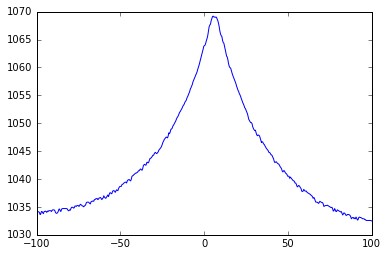

In [10]:
fig, ax = plt.subplots(1,1)
ax.plot(w.x, (1)*w.y/1000/100e-9) #width of #10 graphene/BN is 33um, length between voltage probes is 20um

In [11]:
model = Model(wlcorr, independent_vars=['b'])
params = model.make_params()

In [12]:
params['bo'].value = 3.3877#round_to(1, 0.001) # round to nearest...
# params['bo'].min = low
# params['bo'].max = high
params['ro'].value =3560# round_to(2140, 0.5)
# params['ro'].min = ro-10.0
# params['ro'].max = ro+10.0
params['Bphi'].value = 1
params['Bi'].value = 1
params['Bstar'].value = 30
params['lin'].value = 0
params['A'].value = 1


 #tt=wlcorr(ff.y, 3.3877, 3560, 1, 1, 30, 0, 1)
    
    #(b, bo, ro, Bphi, Bi, Bstar, lin, A):

In [13]:
result = model.fit((1)*w.y/1000/100e-9, params, b=w.x)
print (result.fit_report())

[[Model]]
    Model(wlcorr)
[[Fit Statistics]]
    # function evals   = 569
    # data points      = 500
    # variables        = 7
    chi-square         = 27.203
    reduced chi-square = 0.055
    Akaike info crit   = -1441.649
    Bayesian info crit = -1412.147
[[Variables]]
    bo:      6.07572641 +/- 0.024281 (0.40%) (init= 3.3877)
    ro:      1068.94316 +/- 0.064011 (0.01%) (init= 3560)
    Bphi:    1.81540506 +/- 0.039564 (2.18%) (init= 1)
    Bi:      19.8280077 +/- 2.56e+04 (128943.33%) (init= 1)
    Bstar:   39.6575522 +/- 2.56e+04 (64458.14%) (init= 30)
    lin:    -0.01128096 +/- 0.000206 (1.83%) (init= 0)
    A:       1.53003769 +/- 0.028303 (1.85%) (init= 1)
[[Correlations]] (unreported correlations are <  0.100)
    C(Bi, Bstar)                 = -1.000 
    C(Bphi, A)                   =  0.972 
    C(Bstar, A)                  = -0.890 
    C(Bi, A)                     =  0.890 
    C(Bphi, Bstar)               = -0.787 
    C(Bphi, Bi)                  =  0.787 
    

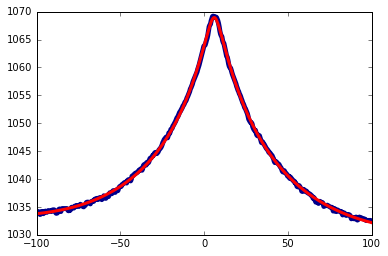

In [14]:
fig, ax = plt.subplots(1,1)
ax.plot(w.x, (1)*w.y/1000/100e-9, color = 'darkblue', linewidth =5)
ax.plot(w.x, wlcorr(w.x, **result.values), color = 'r', linewidth = 3)